In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import gym
import tensorflow as tf

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd "/content/drive/My Drive/pong"

/content/drive/My Drive/pong


In [4]:
env = gym.make('Pong-v0')
NUM_ACTIONS = env.action_space.n

In [5]:
lr = 0.1

In [6]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(4, 4), activation='relu', input_shape=(80, 80, 1)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(2, 2), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(1, 1), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(NUM_ACTIONS, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 77, 77, 32)        544       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 38, 38, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 37, 37, 64)        8256      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 18, 18, 64)        4160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 5184)              0

In [7]:
def prepro(state):
  """ 210x160x3 frame into 80x80 """
  test = 35
  state = state[test:test+160] # crop - remove score and frame
  state = state[::2,::2,0] # downsample by factor of 2.
  state[state == 144] = 0 # erase background (background type 1)
  state[state == 109] = 0 # erase background (background type 2)
  state[state != 0] = 1 # everything else set to 1 for better moving look
  
  return state.astype(np.float32)

In [8]:
def find_motion(s_old,s_new):
  inp = 2*prepro(s_old)-prepro(s_new)
  inp[inp == -1] = 1
  inp[inp == 2] = 0.5
  
  return inp

In [9]:
def evalQ(s_old,s_new):
    inp = find_motion(s_old,s_new)
    out = model(inp[None,...,None])
    return out.numpy()[0]

In [10]:
# take a look, what NN sees
def evalQ1(s_old,s_new):
    inp = find_motion(s_old,s_new)
    plt.imshow(inp, cmap="gray")
    plt.show()

    out = model(inp[None,...,None])
    return out.numpy()[0]

In [11]:
def loss(q1, q2):
    return tf.reduce_sum(tf.square(q1 - q2))

optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
model.compile(loss=loss, optimizer=optimizer)
%cd "/content/drive/My Drive/pong/best_score"
# %cd "/content/drive/My Drive/pong"
model.load_weights('pong_weights')

/content/drive/My Drive/pong/best_score


In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display
def show_state(env, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    # plt.title("%s | Step: %d %s" % (env,step, info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())
    

Game number 0. Draw. Total reward = -7.0


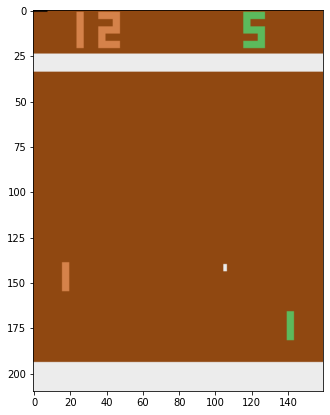

Game number 1. Draw. Total reward = -10.0
Game number 2. Draw. Total reward = -9.0
Game number 3. Draw. Total reward = -6.0


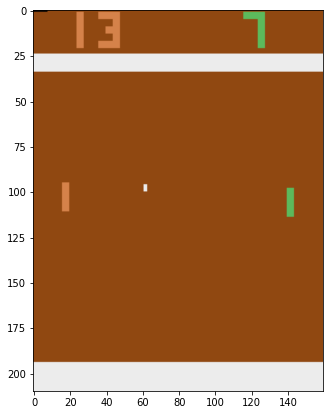

Game number 4. Draw. Total reward = -8.0
Game number 5. Draw. Total reward = -12.0
Game number 6. Draw. Total reward = -9.0
Game number 7. Draw. Total reward = -8.0
Game number 8. Draw. Total reward = -8.0
Game number 9. Draw. Total reward = -9.0
Game number 10. Draw. Total reward = -8.0
Game number 11. Draw. Total reward = -16.0
Game number 12. Draw. Total reward = -13.0
Game number 13. Draw. Total reward = -15.0
Game number 14. Draw. Total reward = -5.0


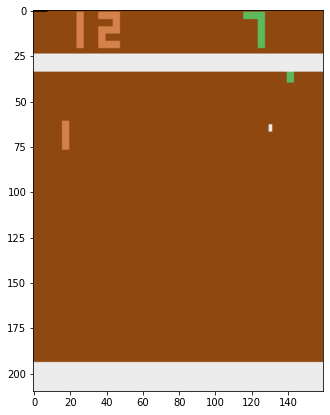

Game number 15. Draw. Total reward = -17.0
Game number 16. Draw. Total reward = -8.0
Game number 17. Draw. Total reward = -10.0
Game number 18. Draw. Total reward = -7.0


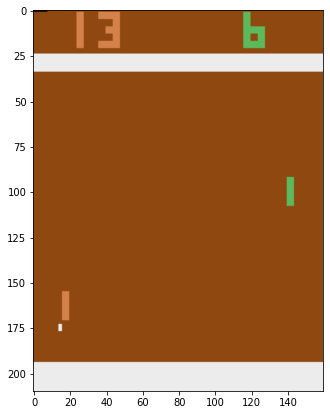

Game number 19. Draw. Total reward = -11.0


In [15]:
test_episodes = 2000
for game_num in range(20):
  totalReward = 0
  s_old = np.zeros((210,160,3))
  s_new = env.reset()
  for i in range(test_episodes):
      # if i%2==0:
      #   show_state(env, i, "")
      #   print(1)
      a = np.argmax(evalQ(s_old,s_new)) 
      
      s_old = s_new
      s_new, r, done, __ = env.step(a)
      totalReward += r
      if done:
          print('Game number {}. Total reward = {}'.format(game_num,totalReward))
          if totalReward > -8:
            plt.figure(figsize=(7, 7))
            plt.imshow(s_new, cmap="gray")
            plt.show()

          break
      elif i==test_episodes-1:
        print('Game number {}. Draw. Total reward = {}'.format(game_num,totalReward))
        if totalReward > -8:
          plt.figure(figsize=(7, 7))
          plt.imshow(s_new, cmap="gray")
          plt.show()
env.close()
